# **IT-890 Practical/Professional Seminar Course Project :** **"Urban Sound Classification"**
### ***Contributed By:-***
Tarushi Jat (202IT029)

### **Notebook III: Training the Model**

****

## **1. Libraries**

In [ ]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sb

import random
from datetime import datetime
from keras.models import Sequential, load_model
from keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from keras.optimizers import Adam
from keras.utils import to_categorical
from keras.regularizers import l2
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

## **2. Urban Sound Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
audio_path = '/content/drive/MyDrive/Projects/UrbanSound'
metadata_path = '/content/drive/MyDrive/Projects/UrbanSound8K.csv'

In [ ]:
metadata = pd.read_csv(metadata_path)
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


## **3. Methods for Performance Metrics Measures & Graph Plotting**

In [ ]:
def evaluate_model(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    test_score = model.evaluate(X_test, y_test, verbose=0)
    return train_score, test_score

In [ ]:
def model_evaluation_report(model, X_train, y_train, X_test, y_test, calc_normal=True):
    dash = '-' * 38
    train_score, test_score = evaluate_model(model, X_train, y_train, X_test, y_test)
    
    print('{:<10s}{:>14s}{:>14s}'.format("", "LOSS", "ACCURACY"))
    print(dash)
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Training:", train_score[0], 100 * train_score[1]))
    print('{:<10s}{:>14.4f}{:>14.4f}'.format( "Test:", test_score[0], 100 * test_score[1]))
    if (calc_normal):
        max_err = max(train_score[0], test_score[0])
        error_diff = max_err - min(train_score[0], test_score[0])
        normal_diff = error_diff * 100 / max_err
        print('{:<10s}{:>13.2f}{:>1s}'.format("Normal diff ", normal_diff, ""))

In [ ]:
def acc_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['accuracy'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_accuracy'],color='#641E16',marker='h')
  plt.title('Accuracy comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def loss_plot(m):
  plt.figure(figsize=(8,5))
  sb.set_style("whitegrid")
  plt.plot(m.history['loss'],color="#E74C3C",marker='o')
  plt.plot(m.history['val_loss'],color='#641E16',marker='h')
  plt.title('Loss comparison between Validation and Train Data set',fontsize=15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Test'], loc='best')
  plt.show()

In [ ]:
def acc_per_class(np_probs_array):    
    accs = []
    for idx in range(0, np_probs_array.shape[0]):
        correct = np_probs_array[idx][idx].astype(int)
        total = np_probs_array[idx].sum().astype(int)
        acc = (correct / total) * 100
        accs.append(acc)
    return accs

## **4. Loading Extracted MFCCs**

In [ ]:
X = np.load("/content/drive/MyDrive/Projects/UrbanSound/X-mfcc.npy")
y = np.load("/content/drive/MyDrive/Projects/UrbanSound/y-mfcc.npy")

## **5. Train and Test Splitting**

In [ ]:
indexes = []
total = 8262 #Some files was corrupted...so I just ignored them.
indexes = list(range(0, total))
random.shuffle(indexes) #Randomizing Indexes

In [ ]:
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

In [ ]:
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]

In [ ]:
#Spliting the features with the same indexes
X_test = np.take(X, test_split_idx, axis=0)
y_test = np.take(y, test_split_idx, axis=0)
X_train = np.take(X, train_split_idx, axis=0)
y_train = np.take(y, train_split_idx, axis=0)

In [ ]:
#Also spliting metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

In [ ]:
print("--------------------Test Data Details--------------------")
print("Test split: {} ".format(len(test_meta)))
print("X test shape: {} ".format(X_test.shape))
print("y test shape: {} ".format(y_test.shape))
print("--------------------Train Data Details--------------------")
print("Train split: {}".format(len(train_meta)))
print("X train shape: {}".format(X_train.shape))
print("y train shape: {}".format(y_train.shape))

--------------------Test Data Details--------------------
Test split: 1652 
X test shape: (1652, 40, 174) 
y test shape: (1652,) 
--------------------Train Data Details--------------------
Train split: 6610
X train shape: (6610, 40, 174)
y train shape: (6610,)


## **6. Normalizing the Data**

In [ ]:
num_rows = 40
num_columns = 174
num_channels = 1

In [ ]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

In [ ]:
# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

In [ ]:
# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]

## **7. CNN Model Architecture**

In [ ]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    model = Sequential()
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate), input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, kernel_size=(3,3), kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
    model.add(GlobalAveragePooling2D())
    model.add(Dense(num_labels, activation='softmax'))
    return model

In [ ]:
#Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005
#Calling Model
model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 32)       1

In [ ]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer=adam)

In [ ]:
history = model.fit(X_train, y_train_encoded, batch_size=128, epochs=250, validation_split=1/12., verbose=1)

Epoch 1/250
48/48 [==============================] - 39s 99ms/step - loss: 2.3008 - accuracy: 0.1846 - val_loss: 2.3756 - val_accuracy: 0.0962
Epoch 2/250
48/48 [==============================] - 4s 74ms/step - loss: 1.9467 - accuracy: 0.3462 - val_loss: 2.4772 - val_accuracy: 0.1053
Epoch 3/250
48/48 [==============================] - 4s 74ms/step - loss: 1.8532 - accuracy: 0.3889 - val_loss: 2.6365 - val_accuracy: 0.1034
Epoch 4/250
48/48 [==============================] - 4s 74ms/step - loss: 1.7517 - accuracy: 0.4170 - val_loss: 2.8727 - val_accuracy: 0.0962
Epoch 5/250
48/48 [==============================] - 4s 74ms/step - loss: 1.7010 - accuracy: 0.4311 - val_loss: 3.0680 - val_accuracy: 0.0962
Epoch 6/250
48/48 [==============================] - 4s 74ms/step - loss: 1.6544 - accuracy: 0.4539 - val_loss: 3.2577 - val_accuracy: 0.0962
Epoch 7/250
48/48 [==============================] - 4s 74ms/step - loss: 1.6002 - accuracy: 0.4637 - val_loss: 3.3428 - val_accuracy: 0.0980
Epoch

## **8. Evaluating model through different performance metrics**

In [ ]:
labels = ['Air Conditioner', 'Car Horn', 'Children Playing', 'Dog bark', 'Drilling', 'Engine Idling', 'Gun Shot', 'Jackhammer', 'Siren', 'Street Music']

### **8.1 Accuracy**

In [ ]:
model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.3209       93.1467
Test:             0.3827       90.3148
Normal diff         16.14 


### **8.2 Visualizing Accuracy in Each Epoch**

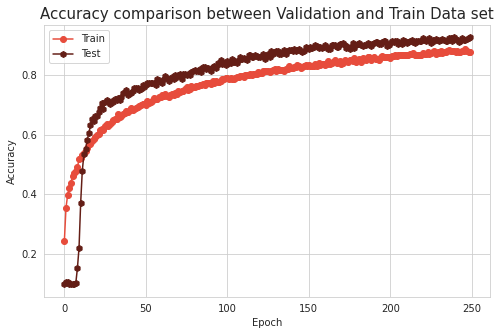

In [ ]:
acc_plot(history)

### **8.3 Visualizing Loss in Each Epoch**

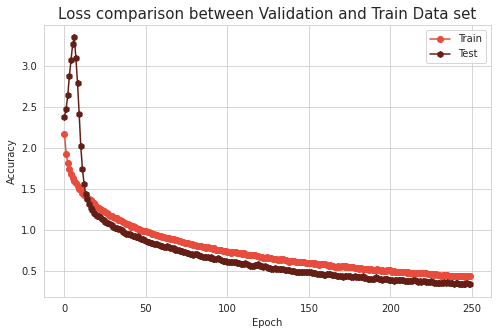

In [ ]:
loss_plot(history)

### **8.4 Confusion Matrix**

In [ ]:
y_probs = model.predict(X_test, verbose=0)
yhat_probs = np.argmax(y_probs, axis=1) #Getting predicted labels
y_trues = np.argmax(y_test_encoded, axis=1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [ ]:
cm = confusion_matrix(y_trues, yhat_probs)
cm

array([[178,   0,   5,   0,   0,   0,   0,   1,   1,   3],
       [  1,  70,   0,   2,   0,   1,   0,   0,   0,   3],
       [  7,   0, 178,   3,   0,   2,   1,   0,   3,  13],
       [  4,   1,  13, 147,   3,   2,   2,   0,   4,   2],
       [  2,   3,   1,   6, 146,   0,   2,   6,   4,   0],
       [  4,   0,   2,   1,   0, 185,   1,   1,   0,   1],
       [  0,   0,   0,   2,   1,   0,  80,   0,   0,   0],
       [  3,   1,   0,   1,   2,   0,   0, 183,   0,   0],
       [  0,   1,   0,   4,   0,   1,   0,   0, 164,   1],
       [ 10,   0,  13,   3,   0,   1,   0,   1,   4, 161]])

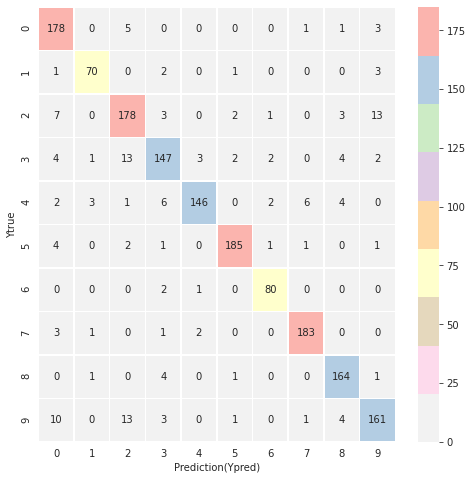

In [ ]:
def display_cm():
  CM = confusion_matrix(y_trues, yhat_probs)
  f, ax = plt.subplots(figsize=(8,8))
  sb.heatmap(CM,annot = True, linewidths=0.5,linecolor="white",fmt=".0f",ax=ax, cmap=plt.cm.Pastel1_r)
  plt.xlabel("Prediction(Ypred)")
  plt.ylabel("Ytrue")
  plt.show()
display_cm()

### **8.5 Classification Report**

In [ ]:
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)
print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.85      0.95      0.90       188
        Car Horn       0.92      0.91      0.92        77
Children Playing       0.84      0.86      0.85       207
        Dog bark       0.87      0.83      0.85       178
        Drilling       0.96      0.86      0.91       170
   Engine Idling       0.96      0.95      0.96       195
        Gun Shot       0.93      0.96      0.95        83
      Jackhammer       0.95      0.96      0.96       190
           Siren       0.91      0.96      0.93       171
    Street Music       0.88      0.83      0.85       193

        accuracy                           0.90      1652
       macro avg       0.91      0.91      0.91      1652
    weighted avg       0.90      0.90      0.90      1652



### **8.6 Accuracy per Class**

In [ ]:
accuracies = acc_per_class(cm)
pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,96.385542
7,Jackhammer,96.315789
8,Siren,95.906433
5,Engine Idling,94.871795
0,Air Conditioner,94.680851
1,Car Horn,90.909091
2,Children Playing,85.990338
4,Drilling,85.882353
9,Street Music,83.419689
3,Dog bark,82.584270


**Done :]**